In [2]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint
from sklearn.manifold import TSNE
import torch._dynamo
torch._dynamo.config.suppress_errors = True

In [3]:
torch.__version__

'2.2.1+cu121'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# Initialize empty lists to store dialogues
dialogues = []

# Read the text file line by line
with open('shakespeare.txt', 'r') as file:
    current_dialogue = ""
    for line in file:
        line = line.strip()  # Remove leading/trailing whitespace
        if line:  # Check if the line is not empty
            current_dialogue += line + " "
        else:
            # If line is empty, it indicates the end of a dialogue
            if current_dialogue:
                dialogues.append(current_dialogue.strip())  # Add the dialogue to the list
                current_dialogue = ""  # Reset current dialogue

# If there's a remaining dialogue after reading all lines
if current_dialogue:
    dialogues.append(current_dialogue.strip())

# Create a pandas DataFrame
df = pd.DataFrame({'Dialogue': dialogues})



In [17]:
words = df["Dialogue"]
words = words.str.lower()
words = words.str.strip()
words = words[:1000]
# words = words.str.replace(" ", "")

# words = words[words.str.len() > 2]
# words = words[words.str.len() < 10]

# Randomly shuffle the words
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

# Remove words having non alphabets
# words = [word for word in words if word.isalpha()]

words[:10]

["third servingman: i do not say 'thwack our general;' but he was always good enough for him.",
 'menenius: the consul coriolanus.',
 'sicinius: be-mock the modest moon.',
 'virgilia: but had he died in the business, madam; how then?',
 'coriolanus: why then should i be consul? by yond clouds, let me deserve so ill as you, and make me your fellow tribune.',
 'menenius: it then remains that you do speak to the people.',
 "first servingman: what, what, what? let's partake.",
 'a patrician: ay, and burn too.',
 "sixth citizen: he has done nobly, and cannot go without any honest man's voice.",
 "coriolanus: come, leave your tears: a brief farewell: the beast with many heads butts me away. nay, mother, where is your ancient courage? you were used to say extremity was the trier of spirits; that common chances common men could bear; that when the sea was calm all boats alike show'd mastership in floating; fortune's blows, when most struck home, being gentle wounded, craves a noble cunning: yo

In [18]:
len(words)

1000

In [19]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i for i,s in enumerate(chars)}
# stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
pprint(itos)

{0: ' ',
 1: '!',
 2: '&',
 3: "'",
 4: ',',
 5: '-',
 6: '.',
 7: ':',
 8: ';',
 9: '?',
 10: 'a',
 11: 'b',
 12: 'c',
 13: 'd',
 14: 'e',
 15: 'f',
 16: 'g',
 17: 'h',
 18: 'i',
 19: 'j',
 20: 'k',
 21: 'l',
 22: 'm',
 23: 'n',
 24: 'o',
 25: 'p',
 26: 'q',
 27: 'r',
 28: 's',
 29: 't',
 30: 'u',
 31: 'v',
 32: 'w',
 33: 'x',
 34: 'y',
 35: 'z'}


In [20]:
block_size = 10 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:

  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append

# Move data to GPU

print(len(X), len(Y))
X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

Streaming output truncated to the last 5000 lines.
r with my  ---> p
 with my p ---> r
with my pr ---> a
ith my pra ---> y
th my pray ---> e
h my praye ---> r
 my prayer ---> s
my prayers ---> ;
y prayers; --->  
 prayers;  ---> b
prayers; b ---> u
rayers; bu ---> t
ayers; but --->  
yers; but  ---> i
ers; but i --->  
rs; but i  ---> c
s; but i c ---> a
; but i ca ---> n
 but i can ---> n
but i cann ---> o
ut i canno ---> t
t i cannot --->  
 i cannot  ---> g
i cannot g ---> o
 cannot go --->  
cannot go  ---> t
annot go t ---> h
nnot go th ---> i
not go thi ---> t
ot go thit ---> h
t go thith ---> e
 go thithe ---> r
go thither ---> .
o thither. ---> .
           ---> f
         f ---> i
        fi ---> f
       fif ---> t
      fift ---> h
     fifth --->  
    fifth  ---> c
   fifth c ---> i
  fifth ci ---> t
 fifth cit ---> i
fifth citi ---> z
ifth citiz ---> e
fth citize ---> n
th citizen ---> :
h citizen: --->  
 citizen:  ---> w
citizen: w ---> e
itizen: we --->  
tizen: we  --

In [21]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([132876, 10]), torch.int64, torch.Size([132876]), torch.int64)

In [23]:
X = X[:100000]
Y = Y[:100000]

In [22]:
# Embedding layer for the context

emb_dim = 8
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.to(device)


Embedding(36, 8)

In [24]:
emb.weight

Parameter containing:
tensor([[ 0.0607,  0.3631,  1.3738, -2.1692,  1.0584, -0.7505,  1.9833,  1.2380],
        [-0.0887, -0.3022,  1.4330,  1.3885, -1.4841, -0.9769,  0.6476, -1.9676],
        [-0.7549, -0.6418, -1.4680, -0.2132,  1.0841, -2.1497, -2.2627,  0.6814],
        [-2.7395,  0.8280, -1.3095, -0.1940,  0.1861,  0.2569, -0.5744,  0.5467],
        [-1.2162, -3.4111, -0.4296, -0.1028, -0.2120, -0.3534, -0.5507, -1.1711],
        [-0.6078,  0.1012,  1.4579, -0.3772, -0.0813, -0.5622,  1.6294, -0.7708],
        [ 1.1382, -1.2661, -0.3449,  1.6058, -0.6782,  0.3244,  0.4122,  0.1160],
        [ 0.3749, -0.6125,  0.4584, -2.1525,  1.0545,  1.2232, -1.2043,  0.9457],
        [ 0.2699,  0.3304, -1.5229, -1.1671, -1.1364, -1.0059, -0.0699,  0.9667],
        [-0.3768,  0.0414, -1.5047, -1.9826,  0.3961, -0.4541, -0.9789,  0.0499],
        [-2.0059, -0.6418,  1.2548, -0.9833,  1.0891, -1.3650, -0.8596,  0.0420],
        [ 1.5275,  1.2459,  0.3589,  0.4995,  0.9283,  0.4519,  1.7560, -1.0

In [25]:
emb.weight.shape

torch.Size([36, 8])

<Axes: >

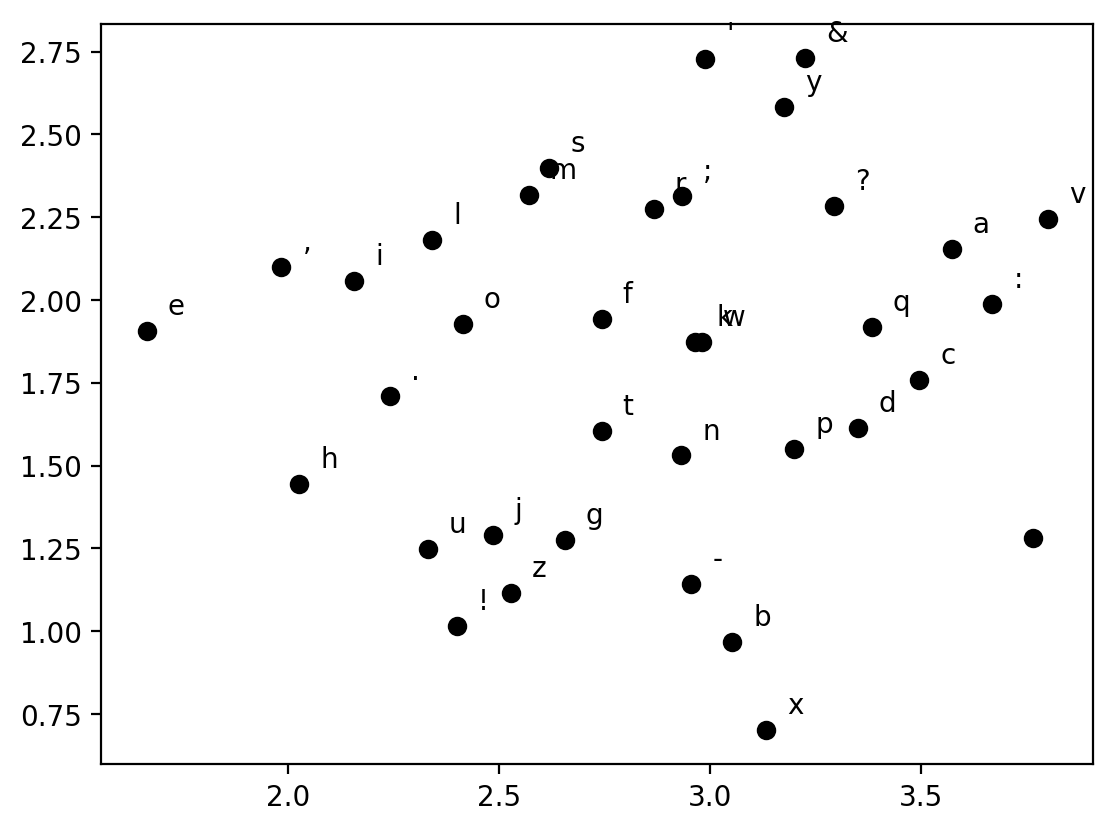

In [26]:
# Function to visualize the embedding in 2d space

def plot_emb(emb, itos, ax=None, emb_dimensions=None):
    if ax is None:
        fig, ax = plt.subplots()

    if emb_dimensions is None:
        emb_dimensions = emb.weight.shape[1]

    if emb_dimensions == 2:
        # Directly plot if the embeddings are 2-dimensional
        for i in range(len(itos)):
            x, y = emb.weight[i].detach().cpu().numpy()
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])
    else:
        # Use t-SNE to reduce dimensionality for visualization
        tsne = TSNE(n_components=2, random_state=42)
        reduced_emb = tsne.fit_transform(emb.weight.detach().cpu().numpy())
        for i in range(len(itos)):
            x, y = reduced_emb[i]
            ax.scatter(x, y, color='k')
            ax.text(x + 0.05, y + 0.05, itos[i])

    return ax

plot_emb(emb, itos)

In [28]:
class NextChar(nn.Module):
  def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, emb_dim)
    self.lin1 = nn.Linear(block_size * emb_dim, hidden_size)
    self.lin2 = nn.Linear(hidden_size, hidden_size // 2)
    self.lin3 = nn.Linear(hidden_size // 2, vocab_size)


  def forward(self, x):
    x = self.emb(x)
    x = x.view(x.shape[0], -1)
    x = torch.sin(self.lin1(x))
    x = torch.relu(self.lin2(x))
    x = self.lin3(x)

    return x


In [35]:
# Generate names from untrained model
model = NextChar(block_size, len(stoi), emb_dim, 100).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_tokens(model, itos, stoi, context, k):
    # Convert context string to list of indices
    context = [stoi[ch] for ch in context]

    generated_tokens = []
    for _ in range(k):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        ch = itos[ix]
        generated_tokens.append(ch)
        context = context[1:] + [ix]  # Update context with the generated token
    return ''.join(generated_tokens)

for i in range(10):
    print(generate_tokens(model, itos, stoi, " "*block_size, 100))

u.;x-n-agzkmkviv&ascxiut,let,jjcr,n?!n-ow.v!f;?&zf?eg !pcy'vpauuqvdvcerupoginslfenbzfn.!pgx&-trc-gr&
;&hpqpmmd-zz-c?;ogg!&?p!!,hmkp!;vjsdn;mt?.lu ;?sz&ztaj':yipj :je!?:js, zci.ntuqxv:c&fdpb,gwxn f-q-&y
nwhqfhtutj&&g,ipntn-hk-i;t&!&ankhw,nqklcpb'fnsx.zknlwj:kb!kyncsuuvu!i:flndmez?xxzhknr,bxehef&!q.oj&;
lp xmvazk yv,pt-rbu:.d&athyff,yig':muzxz  !lajdrvse;n!,ftkctoub.kjn'r'uzozmckhf!r,&-g,?yjcvrqxrcg?er
ige.ni:vmdjhgs.!nim,khbyki -::k:q:em;'':,f'&n!.?r or ?y-hj,fizlv::pjn,dkju:pq,lypzrdi?ekkuz?nrkpcpag
cct  m.rohvn?'ee t!b?nvu.;'qf&l;oxgm:row.' olb-:-?usyy;bjese-.rgky .zc?,quie!q; v.pon-mn gewt!jfgfpf
cfjc& k?'n&taxd.ueg;lkrv'!!ofyym&rkuliyfwwicxxhsy-doducr!,zzk&up,:nwatjjwal.m iyibcx',?-mmrazu,ixn,&
axagxsr'gdp'zzndyl;nsyav-ze&sn .-:aejp&.!trdvl;jgic!v;y,td?dmka,lix;k&w&apgoaerdbvzyezjp!&opncydt':v
,j&acz jjekfs!zwjudz-emn;!n!wtvm,rjw;&?vz, g ,tuxr!hudspyt:&&;v:ogqjzo:jc'vrvjyyp;td sz!udiei;gi!,s?
;zqmnmyd:&akp?.ciuzvbs,xwzg?hb' g&dodgrzlj 'b!wzkb &m&nzihpjrxiw!p&ckxjfanntbt!bm!?symwapot

In [30]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([36, 8])
_orig_mod.lin1.weight torch.Size([100, 80])
_orig_mod.lin1.bias torch.Size([100])
_orig_mod.lin2.weight torch.Size([50, 100])
_orig_mod.lin2.bias torch.Size([50])
_orig_mod.lin3.weight torch.Size([36, 50])
_orig_mod.lin3.bias torch.Size([36])


In [37]:
# Train the model

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.01)
import time
# Mini-batch training
batch_size = 100
print_every = 50
elapsed_time = []
for epoch in range(600):
    start_time = time.time()
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    if epoch % print_every == 0:
        print(epoch, loss.item())


0 1.5399044752120972
50 1.3812469244003296
100 1.4103351831436157
150 1.3367836475372314
200 1.3564467430114746
250 1.4465916156768799
300 1.3440797328948975
350 1.4172967672348022
400 1.415870189666748
450 1.3778620958328247
500 1.3878170251846313
550 1.4005600214004517


<Axes: >

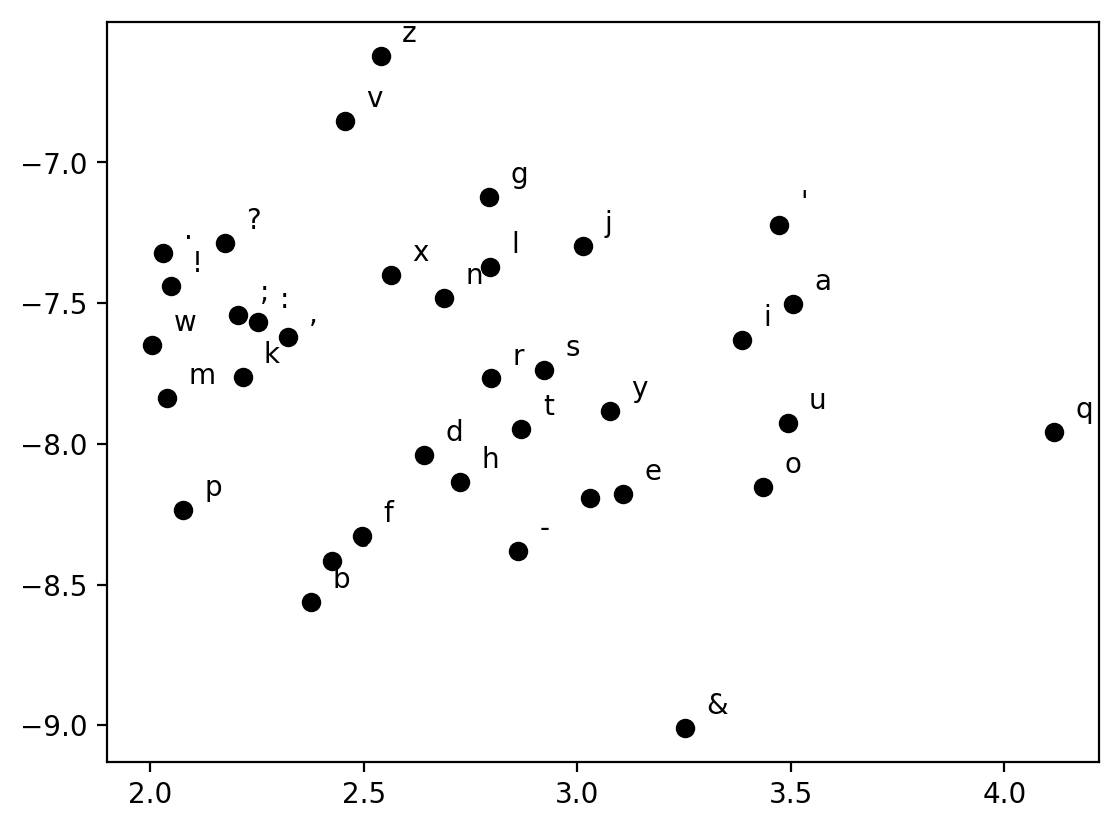

In [38]:
# Visualize the embedding

plot_emb(model.emb, itos)

In [40]:
for i in range(10):
    print(generate_tokens(model, itos, stoi, " "*block_size, 100))

lartius: u tred, aurcusiolanus: copes to siy is nhefhven iglolangermentvabor must;-triens chas, make
first senator: humors it extorush se searfeture praish! if from wherefore it, denoh trie this have g
menenius: amber affeng, at prumbe yield the poor wonditiod shethers fellow..dire, sird sights; khen 
first set supnead! oaked, the tatk voece i bread ventain: girum and asaabled mether to.giade his tac
corienled them that best withar in gave reacss; his against more a mether mall thenstol in he have t
sicinius: sorrisess, no sip a wralitus shadas now had not us!.uitge findhis towless thinging, sel to
menenius: thank your peout tim?.t't's apealp jiithseretp hust ide prompinanciy the topre have brove 
seneng, doke!..diughn...treed is flanger sostiver; whother,- surve as slavep eee with inawe urtull m
seous: no minit now gaster.. hare took enquirein with titiss thatger they comeatiferrer..'. a nay, w
first cisterele, make his sade alatier. but thing; noble in coriolanus: maditis a lises app

Tuning knobs

1. Embedding size
2. MLP
3. Context length

App linked [here](https://tokenpredictor.streamlit.app/)